In [1]:
#Fresh Cortex from Adult Mouse Brain (P50) - Epi ATAC v.10 - fresh
 

In [2]:
install packages
!pip install pandas
!pip install scipy
!pip install pyfaidx
!pip install scikit-learn
!pip install scanpy 
!pip install anndata
!pip install igraph
!pip install leidenalg
import sys
import anndata
print(sys.executable)


/opt/anaconda3/envs/VIB_model/bin/python


In [4]:
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import numpy as np 

#load matrix
matrix = mmread("filtered_peak_bc_matrix/matrix.mtx").tocsc()

#load peaks
peaks = pd.read_csv("filtered_peak_bc_matrix/peaks.bed", sep = "\t", header = None)
barcodes = pd.read_csv("filtered_peak_bc_matrix/barcodes.tsv", header = None)

#assign rows and cols
peaks.columns = ["chr", "start", "end"]
barcodes.columns = ["cell_barcode"]
print(peaks)

         chr     start       end
0       chr1   3094708   3095552
1       chr1   3119414   3121782
2       chr1   3204809   3205178
3       chr1   3217330   3217359
4       chr1   3228123   3228463
...      ...       ...       ...
157792  chrY  90761049  90762169
157793  chrY  90800417  90800831
157794  chrY  90804515  90805440
157795  chrY  90808545  90809111
157796  chrY  90810741  90810960

[157797 rows x 3 columns]


In [5]:
matrix_binary = (matrix>0).astype(int)
#sup per cell - how many cells have that peak accessible /peak cessible per cell - cols are cells but are not shown
peak_accessibility = matrix_binary.sum(axis=1)

print(peak_accessibility)
#convert to A1 numpy array
peaks_accessibility_1D = peak_accessibility.A1

[[260]
 [731]
 [ 86]
 ...
 [453]
 [407]
 [ 61]]


In [6]:
#Perform Pre-processing with Scanpy
matrix_Transposed = matrix_binary.T # trasnpose the matrix so it is cells x peaks - Scanpy expect that 
#assign barcodes columns

#create AnnData object (Scanpy's mani data structure)
adata = anndata.AnnData(X = matrix_Transposed)
adata.obs_names = barcodes['cell_barcode'].values
print(adata.shape) #cells, peaks, (5K, 197K pekas)

(5337, 157797)


In [7]:
#Step 2: perform TF-IDF normalzaition 
from sklearn.feature_extraction.text import TfidfTransformer
tf_idf = TfidfTransformer()
X_tfidf = tf_idf.fit_transform(adata.X)

#update anndata with normalized data
adata.X = X_tfidf


In [8]:
#Step 3: perform Dim. Rduction via LSI

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=42) #many sc-atc - seq use 30-100 components.  Random state for reproducability
#analyse data to learna PC, and projecct the high dimd ata to lower dim space spanneds by these PC.
X_lsi = svd.fit_transform(adata.X)

#store as PCA embedding
adata.obsm["X_lsi"] = X_lsi

In [10]:
#Step4: neighbors and clustering
import scanpy
#Build nearest neighbors graphs oc cells using LSI components
scanpy.pp.neighbors(adata, use_rep="X_lsi", n_neighbors=15
                   )
#Run umap fo visualization by embedding cells in 2d or 3d spcace
scanpy.tl.umap(adata) 
#Perform Leiden clustering on the neighbor graph.
scanpy.tl.leiden(adata, resolution=0.5) # clusters cell into subgroups


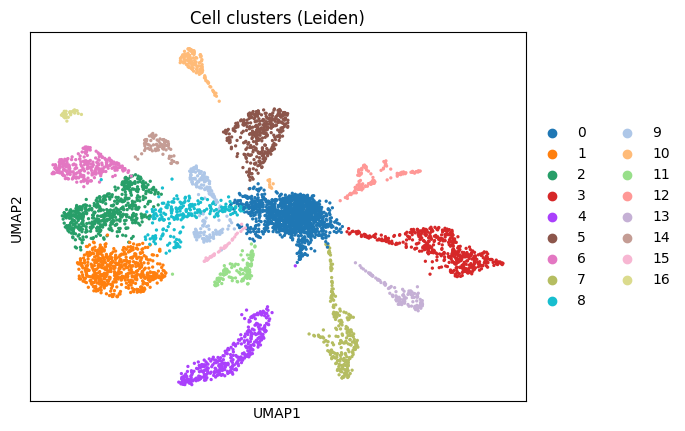

In [11]:
#Step 5 : visualize clusters with UMAP
import matplotlib.pyplot as plt
scanpy.pl.umap(adata, color = "leiden", title = "Cell clusters (Leiden)")

In [12]:
from pyfaidx import Fasta
#load genome  Fasta file
genome = Fasta("Genomes/Mus_musculus.GRCm39.dna.primary_assembly.fa")

#replace chr as str name because in genome there is only number
peaks['chr'] = peaks['chr'].str.replace('chr',"")
#function to get sequence
def get_sequence(row):
    return genome[row['chr']][row['start']:row['end']].seq

peaks['sequence'] = peaks.apply(get_sequence, axis=1) #aply the funcition getsequences


In [13]:
#Pad if seq < 150nt or trim it if is is larger
def pad_or_trim(seq, window_size = 150):
    seq = seq.upper()
    if len(seq) > window_size:
        return seq[:window_size]
    return seq + "N" * (window_size - len(seq)) #Pad with Ns


#Create one hot encoding function for the sequence
def one_hot_encoding(sequence):
    mapping = {"A":0, "C":1, "G":2, "T":3}
    one_hot = np.zeros((len(sequence), 4), dtype = np.int8) #rows-len of seq, and cols 4 possible nts
    for i, nt in enumerate(sequence.upper()):
        if nt in mapping:
            one_hot[i, mapping[nt]] = 1
    return one_hot


#add trimmed seq in the peaks 
peaks['trimmed_sequence'] = peaks['sequence'].apply(pad_or_trim)

#for all seqs
encoded_sequences = [one_hot_encoding(seq) for seq in peaks['trimmed_sequence']]


In [14]:
#PRepere the data for training
import numpy as np
#Subsample peaks and cells, because 5K cells pairing with  197K peaks, leads to explosion s
n_peaks = 5000
n_cells = 1000

selected_peaks = np.random.choice(peaks.index.values, n_peaks, replace = False)
selected_cells_barcodes = np.random.choice(barcodes["cell_barcode"].values, n_cells, replace = False)
#map cells barcods to integer positions
barcode_to_idx = {barcode: i for i, barcode in enumerate(barcodes['cell_barcode'].values)}
selected_cell_indices = [barcode_to_idx[bc] for bc in selected_cells_barcodes]

#Step 2: subset the binary accessibility matrix
matrix_sub = matrix_binary[selected_peaks, :][:, selected_cell_indices]

#Prepeare sequence input
X_seq_sub = np.stack([encoded_sequences[i] for i in selected_peaks]) #shape (n_peaks, 150, 4)
X_seq_sub = np.repeat(X_seq_sub, repeats=n_cells, axis=0)  #shape (n_peaks*n_cells, 150, 4)




from sklearn.preprocessing import OneHotEncoder

cell_clusters_sub = adata.obs.loc[selected_cells_barcodes, 'leiden'].values.reshape(-1, 1)
enc = OneHotEncoder(sparse_output=False)
X_cell_onehot = enc.fit_transform(cell_clusters_sub)  # shape (n_cells, num_clusters)

# Repeat cell cluster vectors for each peak
X_cell_sub = np.tile(X_cell_onehot, (n_peaks, 1))  # shape (n_peaks*n_cells, num_clusters)




y_sub = matrix_sub.toarray().T.flatten()  # shape (n_peaks*n_cells,)



from sklearn.model_selection import train_test_split

X_seq_train, X_seq_test, X_cell_train, X_cell_test, y_train, y_test = train_test_split(
    X_seq_sub, X_cell_sub, y_sub, test_size=0.2, random_state=42
)

print(X_seq_train.shape, X_cell_train.shape, y_train.shape)
print(X_seq_test.shape, X_cell_test.shape, y_test.shape)





(4000000, 150, 4) (4000000, 17) (4000000,)
(1000000, 150, 4) (1000000, 17) (1000000,)


In [15]:
#Use multi task with DNA sequence and cell type from cluster as input
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

seq_input = layers.Input(shape=(150,4), name = "sequence_input")

#CNN on DNA
x = layers.Conv1D(64,10, activation = "relu")(seq_input)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128,10, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)

#input cell type z
cell_type_input = layers.Input(shape = (17,), name = "cell_type_input")


#Concatenate features
combined = Concatenate()([x,cell_type_input])
combined = Dense(64, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(1, activation = "linear", name = "accessibility")(combined)

#build model
model = Model(inputs=[seq_input, cell_type_input], outputs = output)
model.compile(optimizer="adam", loss="mse", metrics =["mse"])



#fit model
#fit model 

model.fit(
    [X_seq_train, X_cell_train], y_train,
    validation_data=([X_seq_test, X_cell_test], y_test),
    epochs=5,#low epochs due to running time 
    batch_size=32
)

Epoch 1/5
125000/125000 ━━━━━━━━━━━━━━━━━━━━ 514s 4ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 2/5
125000/125000 ━━━━━━━━━━━━━━━━━━━━ 460s 4ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 3/5
125000/125000 ━━━━━━━━━━━━━━━━━━━━ 480s 4ms/step - loss: 0.0500 - mse: 0.0500 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 4/5
125000/125000 ━━━━━━━━━━━━━━━━━━━━ 508s 4ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0502 - val_mse: 0.0502
Epoch 5/5
125000/125000 ━━━━━━━━━━━━━━━━━━━━ 522s 4ms/step - loss: 0.0502 - mse: 0.0502 - val_loss: 0.0503 - val_mse: 0.0503


In [18]:
#Unique cell types
cell_clusters = adata.obs['leiden']
print(cell_clusters)



AAACGAAAGTAATCAG-1     6
AAACGAACACGCTGTG-1     1
AAACGAATCCTGGGAC-1     6
AAACGAATCGGGAAAC-1     7
AAACTCGAGAAAGCAG-1     1
                      ..
TTTGTGTGTGCTTCCT-1     0
TTTGTGTGTGGCATAG-1     8
TTTGTGTTCAGGGTTT-1     5
TTTGTGTTCTCTGCGT-1     2
TTTGTGTTCTTACTCA-1    13
Name: leiden, Length: 5337, dtype: category
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']


In [16]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict([X_seq_test, X_cell_test])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
Test MSE: 0.0503
Test R²: -0.0028
